In [1]:
import os
import sys

import numpy as np
import copy

from glob import glob
import argparse

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
fpga = {}
fpga['DSP48E'] = 5520
fpga['BRAM_18K'] = 4320
fpga['FF'] = 1326720
fpga['LUT'] = 663360

In [3]:
MODEL = 'BatchNormTrue_MaskingFalse'
MODELLSTM = f"lstm_{MODEL}_28062022_10.27.00"
MODELGRU = f"gru_{MODEL}_28062022_06.21.52"
reuses = [1, 5, 10, 50, 100]
reuses_labels = reuses
INTBIT = 8

fld = "/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls/"

files_loc_lstm = f"{fld}/{MODELLSTM}/reports/*.txt"
files_loc_gru = f"{fld}/{MODELGRU}/reports/*.txt"

In [4]:
plot_loc = f'model_plots/{MODEL}'

if not os.path.exists(plot_loc):
    os.makedirs(plot_loc)

In [20]:
files = glob(files_loc_lstm) + glob(files_loc_gru)

In [21]:
files

['/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormTrue_MaskingFalse_28062022_10.27.00/reports/model_26.8_reuse_5_Latency_Static_BigTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormTrue_MaskingFalse_28062022_10.27.00/reports/model_26.2_reuse_100_Latency_Static_BigTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormTrue_MaskingFalse_28062022_10.27.00/reports/model_26.4_reuse_50_Latency_Static_BigTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormTrue_MaskingFalse_28062022_10.27.00/reports/model_12.4_reuse_10_Latency_Static_BigTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormTrue_MaskingFalse_28062022_10.27.00/reports/model_30.6_reuse_5_Latency_Static_BigTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormTrue_MaskingFalse_28062022_10.27.00/reports/model_10.4_reuse_5_Latency_Static_BigTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl

In [23]:
base_dict = {
    'name':'',
    'file': '',
    'BRAM_18K': -1,
    'DSP48E': -1,
    'FF': -1,
    'LUT': -1,
    'URAM':-1,
    'LAT_min':-1,
    'LAT_max': -1,
    'INT_min': -1,
    'INT_max': -1,
    'ap_tot': -1,
    'ap_frac': -1,
    'ap_int': -1,
    'ap_quant': '',
    'ap_over': '',
    'strategy': '',
    'reuse': -1,
    'keras_auc': -1,
    'hls_auc': -1,
    'rel_auc': -1,
    'model': '',
    'static': 1,
    'mac_max': -1,
    'mac_min': -1,
    'npar': -1
}

In [24]:
dicts = []

lat_unit = 'us'

for ff in files:
    with open(ff, 'r') as hf:

        this_dict = copy.deepcopy(base_dict)
        this_dict['name'] = ff.split('/')[-1].replace('.txt', '')
        this_dict['file'] = ff
        
        this_dict['reuse'] = int(this_dict['name'].split('_reuse_')[-1].split('_')[0])
        this_dict['strategy'] = this_dict['name'].split('_reuse_')[-1].split('_')[1]

        modes = this_dict['name'].split('_reuse_')[0].replace('model_', '').split('.')
        
        if 'NonStatic' in ff: this_dict['static'] = 0

        this_dict['ap_tot'] = int(modes[0])
        this_dict['ap_int'] = int(modes[1])
        this_dict['ap_frac'] = this_dict['ap_tot'] - this_dict['ap_int']
        this_dict['ap_quant'] = 'std' if len(modes) < 3 else modes[2]
        this_dict['ap_over'] = 'std' if len(modes) < 3 else modes[3]
        this_dict['model'] = 'gru' if 'GRU' in ff or 'gru' in ff else 'lstm'
        # this_dict['npar'] = n_params_gru if 'GRU' in ff or 'gru' in ff else n_params_lstm

        for line in hf:
            if 'function' in line or 'none' in line or 'dataflow' in line:
                if '_' in line: continue
                
                sline = line.split()
                sline = [ sl.replace('|', '') for sl in sline ]

                this_dict['LAT_min'] = float(sline[3])
                this_dict['LAT_max'] = float(sline[6])
                
                this_dict['INT_min'] = float(sline[9])
                this_dict['INT_max'] = float(sline[10])
                
                this_dict['mac_max'] = float(this_dict['npar'])/float(this_dict['INT_max'])
                this_dict['mac_min'] = float(this_dict['npar'])/float(this_dict['INT_min'])
                
                # if sline[4] != sline[7]:
                #     print(sline[4], sline[7])
                #     break
                
                if 'ms' in sline[4]:
                    this_dict['LAT_min'] = this_dict['LAT_min']*1e3
                if 'ns' in sline[4]:
                    this_dict['LAT_min'] = this_dict['LAT_min']*1e-3
                    
                if 'ms' in sline[7]:
                    this_dict['LAT_max'] = this_dict['LAT_max']*1e3
                if 'ns' in sline[7]:
                    this_dict['LAT_max'] = this_dict['LAT_max']*1e-3
    
                # if 'none' in lat_unit:
                #     lat_unit = sline[4]
                # else:
                #     assert sline[4] == lat_unit

            if 'Total' in line and this_dict['FF'] == -1:
                sline = line.split()
                sline = [ sl.replace('|', '') for sl in sline ]
                
                this_dict['BRAM_18K']  = int( sline[2] )
                this_dict['DSP48E']    = int( sline[3] )
                this_dict['FF']        = int( sline[4] )
                this_dict['LUT']       = int( sline[5] )
                this_dict['URAM']      = int( sline[6] )
            
            if 'KERAS_AUC' in line:
                sline = line.split()
                this_dict['keras_auc'] = float(sline[1])

            if 'HLS_AUC' in line:
                sline = line.split()
                this_dict['hls_auc'] = float(sline[1])

        # this_dict['rel_auc'] = abs( this_dict['keras_auc'] - this_dict['hls_auc'] ) / this_dict['keras_auc']
        this_dict['rel_auc'] = abs( this_dict['hls_auc'] ) / this_dict['keras_auc']
        dicts.append(this_dict)

In [25]:
tot_dict = copy.deepcopy(base_dict)

for kk in tot_dict:
    tot_dict[kk] = [ dd[kk] for dd in dicts]

In [26]:
tot_dict

{'name': ['model_26.8_reuse_5_Latency_Static_BigTable',
  'model_26.2_reuse_100_Latency_Static_BigTable',
  'model_26.4_reuse_50_Latency_Static_BigTable',
  'model_12.4_reuse_10_Latency_Static_BigTable',
  'model_30.6_reuse_5_Latency_Static_BigTable',
  'model_10.4_reuse_5_Latency_Static_BigTable',
  'model_16.10_reuse_1_Latency_Static_BigTable',
  'model_20.6_reuse_100_Latency_Static_BigTable',
  'model_12.12_reuse_50_Latency_Static_BigTable',
  'model_18.12_reuse_1_Latency_Static_BigTable',
  'model_12.12_reuse_1_Latency_Static_BigTable',
  'model_14.2_reuse_1_Latency_Static_BigTable',
  'model_24.6_reuse_5_Latency_Static_BigTable',
  'model_18.12_reuse_10_Latency_Static_BigTable',
  'model_26.2_reuse_5_Latency_Static_BigTable',
  'model_18.4_reuse_5_Latency_Static_BigTable',
  'model_28.10_reuse_10_Latency_Static_BigTable',
  'model_10.12_reuse_1_Latency_Static_BigTable',
  'model_26.10_reuse_50_Latency_Static_BigTable',
  'model_12.2_reuse_5_Latency_Static_BigTable',
  'model_30.12

In [27]:
import pandas as pd

In [28]:
pd_dict = pd.DataFrame.from_dict(tot_dict)

In [29]:
pd_dict[pd_dict.model=='lstm']

,name,file,BRAM_18K,DSP48E,FF,LUT,URAM,LAT_min,LAT_max,INT_min,...,strategy,reuse,keras_auc,hls_auc,rel_auc,model,static,mac_max,mac_min,npar
0,model_26.8_reuse_5_Latency_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,51,849,55030,154767,0,0.845,0.845,144.0,...,Latency,5,0.984516,0.778624,0.790869,lstm,1,-0.006944,-0.006944,-1
1,model_26.2_reuse_100_Latency_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,51,176,76209,108971,0,7.680,7.680,1536.0,...,Latency,100,0.984516,0.461318,0.468574,lstm,1,-0.000651,-0.000651,-1
2,model_26.4_reuse_50_Latency_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,51,229,75545,115121,0,4.030,4.030,806.0,...,Latency,50,0.984516,0.532145,0.540514,lstm,1,-0.001241,-0.001241,-1
3,model_12.4_reuse_10_Latency_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,51,324,24990,92733,0,0.940,0.940,156.0,...,Latency,10,0.984516,0.609356,0.618939,lstm,1,-0.006410,-0.006410,-1
4,model_30.6_reuse_5_Latency_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,51,1332,82220,152244,0,0.850,0.850,144.0,...,Latency,5,0.984516,0.499900,0.507762,lstm,1,-0.006944,-0.006944,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,model_30.2_reuse_5_Latency_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,51,2214,81443,146304,0,0.785,0.785,132.0,...,Latency,5,0.984516,0.461579,0.468839,lstm,1,-0.007576,-0.007576,-1
356,model_30.2_reuse_1_Latency_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,51,7436,63028,176760,0,0.465,0.465,84.0,...,Latency,1,0.984516,0.461579,0.468839,lstm,1,-0.011905,-0.011905,-1
357,model_28.8_reuse_50_Latency_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,51,350,82737,121919,0,4.150,4.150,830.0,...,Latency,50,0.984516,0.778556,0.790801,lstm,1,-0.001205,-0.001205,-1
358,model_10.8_reuse_100_Latency_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,51,20,3614,42018,0,0.455,0.455,84.0,...,Latency,100,0.984516,0.500000,0.507864,lstm,1,-0.011905,-0.011905,-1


In [30]:
def get_plot(st, reu, apint, var, model, max_x = 18, stat=1):
    xi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.model == model) & (pd_dict.static == stat) ].ap_frac.to_numpy()
    yi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.model == model) & (pd_dict.static == stat) ][var].to_numpy()
    sort_i = xi.argsort()
    x = np.array(xi[sort_i], dtype=int)
    y = yi[sort_i]
    y = y[x < max_x+1]
    x = x[x < max_x+1]
    return [x,y]

In [31]:
def get_plot_tot(st, reu, apint, var, model, max_x = 18, stat=1):
    xi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.model == model) & (pd_dict.static == stat) ].ap_tot.to_numpy()
    yi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.model == model) & (pd_dict.static == stat) ][var].to_numpy()
    sort_i = xi.argsort()
    x = np.array(xi[sort_i], dtype=int)
    y = yi[sort_i]
    y = y[x < max_x+1]
    x = x[x < max_x+1]
    return [x,y]

In [32]:
get_plot('Latency', 5, 6, 'rel_auc', model='lstm')

[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 array([0.50786353, 0.15600318, 0.5051209 , 0.50786353, 0.50786353,
        0.50786353, 0.50776195, 0.50776195, 0.50776195])]

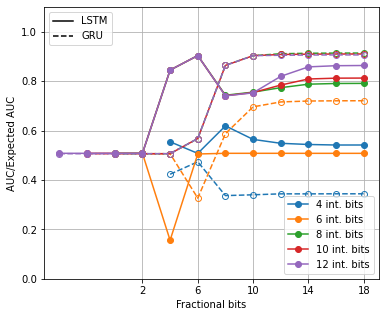

In [34]:
strat = 'Latency'

vars = ['rel_auc']
var_labs = [ r'AUC/Expected AUC']
reuse_to_plot=1

for reuse in [reuse_to_plot]:
    
    for ivv,vv in enumerate(vars):
        

        fig, ax = plt.subplots(1,1,figsize=(6,5))
        
        myplot = get_plot(strat, reuse, 4, vv, model='lstm')
        ax.plot( myplot[0],myplot[1], 'o-', color='C0', label='4 int. bits' )
        
        myplot = get_plot(strat, reuse, 4, vv, model='gru')
        ax.plot( myplot[0],myplot[1], 'o--', color='C0', fillstyle='none' )
        ax.set_xticks(np.arange(min(myplot[0]), max(myplot[0])+1, 4.0))

        myplot = get_plot(strat, reuse, 6, vv, model='lstm')
        ax.plot( myplot[0],myplot[1], 'o-', color='C1', label='6 int. bits' )
        
        myplot = get_plot(strat, reuse, 6, vv, model='gru')
        ax.plot( myplot[0],myplot[1], 'o--', color='C1', fillstyle='none' )
        ax.set_xticks(np.arange(min(myplot[0]), max(myplot[0])+1, 4.0))

        myplot = get_plot(strat, reuse, 8, vv, model='lstm')
        ax.plot( myplot[0],myplot[1], 'o-', color='C2', label='8 int. bits' )
        
        
        myplot = get_plot(strat, reuse, 8, vv, model='gru')
        ax.plot( myplot[0],myplot[1], 'o--', color='C2', fillstyle='none' )

        myplot = get_plot(strat, reuse, 10, vv, model='lstm')
        ax.plot( myplot[0],myplot[1], 'o-', color='C3', label='10 int. bits' )

        myplot = get_plot(strat, reuse, 10, vv, model='gru')
        ax.plot( myplot[0],myplot[1], 'o--', color='C3', fillstyle='none' )
        
        myplot = get_plot(strat, reuse, 12, vv, model='lstm')
        plt.plot( myplot[0],myplot[1], 'o-', color='C4', label='12 int. bits' )
        
        myplot = get_plot(strat, reuse, 12, vv, model='gru')
        plt.plot( myplot[0],myplot[1], 'o--', color='C4', fillstyle='none' )
        

        # plt.legend(title=f'Strat.: {strat},\n Reuse: {reuse}', frameon=False)
        ax.legend(frameon=True, loc='lower right')
        # plt.legend(frameon=False)
        ax.set_xlabel('Fractional bits')
        if 'LAT' in vv:
            ax.set_ylabel(var_labs[ivv]+f' ({lat_unit})')
        else:
            ax.set_ylabel(var_labs[ivv])
            

        lines = [mpl.lines.Line2D([0], [0], ls='-', color='black', ),
                     mpl.lines.Line2D([0], [0], ls='--', color='black')]
        
        leg = mpl.legend.Legend(ax, lines, labels=['LSTM', 'GRU'],
            loc='upper left', frameon=True)
        ax.add_artist(leg)

        plt.ylim(0,1.1)
        # plt.title(model_name, loc='left', fontweight="bold")
        plt.grid()
        plt.savefig(f"{plot_loc}/{vv}_{reuse}.pdf")
        plt.show()

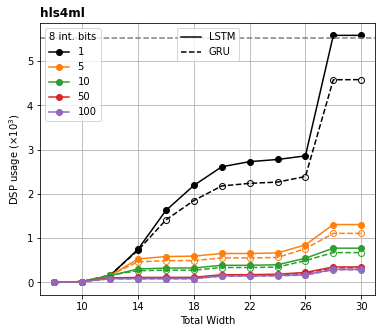

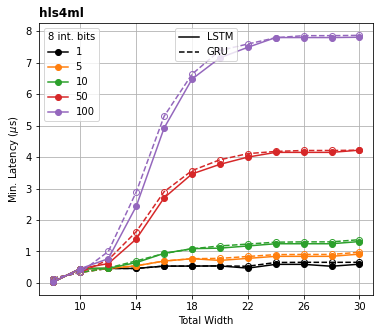

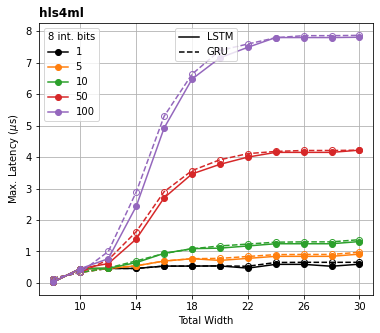

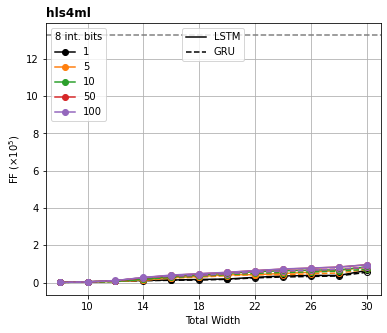

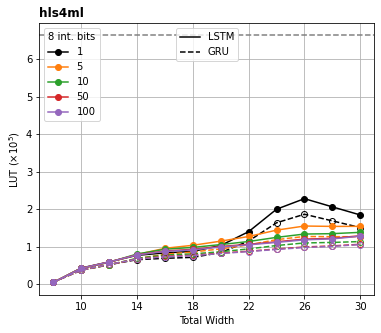

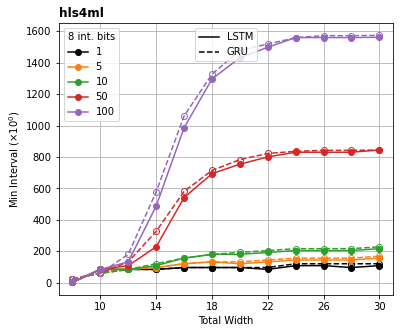

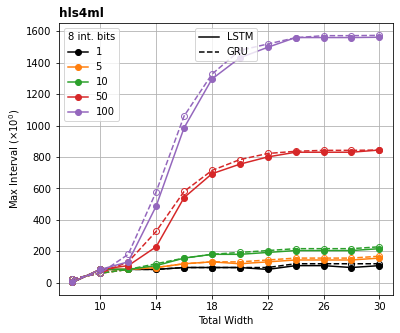

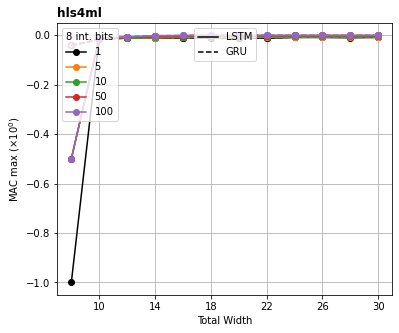

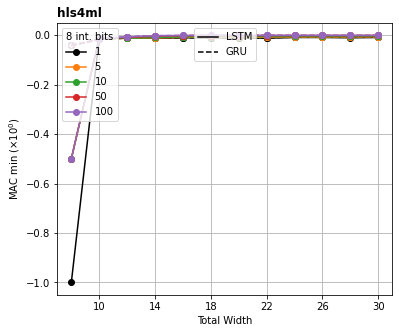

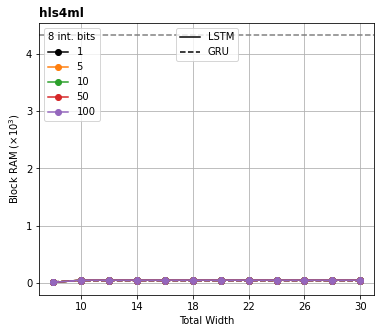

In [35]:
dft_strat = 'Latency'

vars = ['DSP48E', f'LAT_min', f'LAT_max', 'FF', 'LUT', 'INT_min', 'INT_max', 'mac_max', 'mac_min', 'BRAM_18K']
var_labs = ['DSP usage', f'Min. Latency', f'Max. Latency', 'FF', 'LUT', 
            'Min Interval', 'Max Interval', 'MAC max', 'MAC min', 'Block RAM']
facts = [3, 0, 0, 5, 5, 0, 0, 0, 0, 3]
    
for ivv,vv in enumerate(vars):

    fig, ax = plt.subplots(1,1,figsize=(6,5))
    # plt.xlim(9,31)

    # for ire,reuse in enumerate([50, 100, 200, 500, 1000, 2000]):
    # for ire,reuse in enumerate([50, 100, 200, 1000]):
    for ire,reuse in enumerate(reuses):
        
        col=f'C{ire}'
        strat = dft_strat
        if reuse == 1:
            strat = 'Latency'
            col = 'black'
        
        myplot = get_plot_tot(strat, reuse, INTBIT, vv, 'lstm', 30)
        ax.plot( myplot[0],myplot[1]/(10**facts[ivv]), 'o-', color=col, label=reuses_labels[ire] )
        
        myplot = get_plot_tot(strat, reuse, INTBIT, vv, 'gru', 30)
        ax.plot( myplot[0],myplot[1]/(10**facts[ivv]), 'o--', color=col, fillstyle='none' )
        
    
    ax.set_xticks(np.arange(10, 31, 4.0))
    ax.set_xlim(7,31)

    # ax.legend(title=f'{INTBIT} int. bits'+'\n'+f'Dense R = {dense_reuse}', frameon=True,
    #           loc='upper left')
    ax.legend(title=f'{INTBIT} int. bits', frameon=True,
              loc='upper left')
    # plt.legend(frameon=False)
    ax.set_xlabel('Total Width')
    if 'LAT' in vv:
        # ax.set_yscale('log')
        unit = lat_unit.replace('u', '$\\mu$')
        ax.set_ylabel(var_labs[ivv] +f' ({unit})')
    else:
        ax.set_ylabel(var_labs[ivv] +f' ($\\times 10^{str(facts[ivv])} $)')
        
    lines = [mpl.lines.Line2D([0], [0], ls='-', color='black', ),
                     mpl.lines.Line2D([0], [0], ls='--', color='black')]
        
    leg = mpl.legend.Legend(ax, lines, labels=['LSTM', 'GRU'],
            loc='upper center', frameon=True)
            # bbox_to_anchor=(0.55, 1.), frameon=True)
    ax.add_artist(leg)
    
    if vv in fpga:
        ax.plot([7,31], [fpga[vv]/(10**facts[ivv]), fpga[vv]/(10**facts[ivv])], '--', color='gray') 

    plt.title('hls4ml', loc='left', fontweight="bold")
    plt.grid()
    plt.savefig(f"{plot_loc}/{vv}_reuseScan.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
dft_strat = 'Resource'

vars = [f'LAT_min', f'LAT_max']
var_labs = [f'Min. Latency', f'Max. Latency']

    
latex_table = '\\begin{table}\n\\centering\n\\begin{tabular}{'
for il in range(len(reuses)+1):
    latex_table += ' c '
latex_table += '}\n'

latex_table += ' & '
for ire,reuse in enumerate(reuses):
    latex_table += f' {reuses_labels[ire]} '
    if ire+1 < len(reuses):
        latex_table += ' & '
    else:
        latex_table += ' \\\\ \\hline \n'
            
latex_table += ' GRU: & '
for ire,reuse in enumerate(reuses):

    strat = dft_strat
    if reuse == 1:
        strat = 'Latency'

    gru_myplot_min = get_plot(strat, reuse, opt_ap_int_gru, f'LAT_min', 'gru')
    gru_myplot_max = get_plot(strat, reuse, opt_ap_int_gru, f'LAT_max', 'gru')
    
    gru_lat_min = gru_myplot_min[1][ np.where( gru_myplot_min[0] == opt_ap_frac_gru ) ][0]
    gru_lat_max = gru_myplot_max[1][ np.where( gru_myplot_max[0] == opt_ap_frac_gru ) ][0]
    
    latex_table += f' {gru_lat_min:.1f} - {gru_lat_max:.1f} ' + r'$\mu$s'
    if ire+1 < len(reuses):
        latex_table += ' & '
    else:
        latex_table += ' \\\\ \n'
            
latex_table += ' LSTM: & '
for ire,reuse in enumerate(reuses):

    strat = dft_strat
    if reuse == 1:
        strat = 'Latency'

    lstm_myplot_min = get_plot(strat, reuse, opt_ap_int_lstm, f'LAT_min', 'lstm')
    lstm_myplot_max = get_plot(strat, reuse, opt_ap_int_lstm, f'LAT_max', 'lstm')
    
    lstm_lat_min = lstm_myplot_min[1][ np.where( lstm_myplot_min[0] == opt_ap_frac_lstm ) ][0]
    lstm_lat_max = lstm_myplot_max[1][ np.where( lstm_myplot_max[0] == opt_ap_frac_lstm ) ][0]
    
    latex_table += f' {lstm_lat_min:.1f} - {lstm_lat_max:.1f} ' + r'$\mu$s'
    if ire+1 < len(reuses):
        latex_table += ' & '
    else:
        latex_table += ' \\\\ \n'

latex_table += '\\end{tabular}\n'
latex_table += '\\caption{ Minimum and maximum latencies for the ' + model_name + ' model.}'
latex_table += '\n\\end{table}'
print(latex_table)
print()